
# Does pruning discard true motifs? A power demo

**Goal.** Quantify whether candidate pruning (Step 5: inverted index on rare features) *keeps* motif-containing windows and motif–motif pairs with high probability, while still drastically reducing comparisons.

## What we measure (deeper explanation)

Let each window be a set of features \(A \subset \{1,\dots,M\}\) where each feature is a (neuron, bin) pair. A true 5‑spike motif is a fixed set \(T\) of 5 features. We embed the same \(T\) in \(m\) windows per replicate.

We evaluate:

1. **Pair recall at pruning**  
   For each replicate, consider all \(\binom{m}{2}\) true motif–motif pairs. A pair \((i,j)\) *survives pruning* if it appears in the **candidate set** (i.e., they share ≥ `r_shared` rare features chosen from each window).  
   - Statistic: \( R_\text{pair, prune} = \frac{\#\{\text{true motif pairs that are candidates}\}}{\binom{m}{2}} \).  
   Pooled across replicates, this is a binomial proportion with total trials \(N_\text{pairs}\) and successes \(K_\text{pairs}\).

2. **Pair recall after significance**  
   Build exact intersections \(|A\cap B|\) only for candidate pairs, compute a **hypergeometric** tail p‑value under the null of independent spikes given the two window sizes, and control FDR (Benjamini–Hochberg).  
   - Statistic: \( R_\text{pair, sig} = \frac{\#\{\text{true motif pairs declared significant}\}}{\binom{m}{2}} \).

3. **Window support recall**  
   A motif window is **supported** if it links to at least one *other* motif window:  
   - At pruning: \( R_\text{win, prune} = \frac{\#\{\text{motif windows with ≥1 candidate edge to another motif window}\}}{m} \).  
   - After significance: \( R_\text{win, sig} = \frac{\#\{\text{motif windows with ≥1 significant edge to another motif window}\}}{m} \).  
   These are also pooled binomial proportions across replicates.

4. **Precision after significance**  
   Among edges called significant, the fraction that truly connect two motif windows:  
   \( P_\text{edges} = \frac{\#\{\text{significant motif–motif edges}\}}{\#\{\text{all significant edges}\}} \).

**Why these metrics?**  
- Pair recall asks the hardest question: do we keep the **relationships** among motif windows through pruning and testing?  
- Window recall ensures *each* motif window retains evidence (links) to others.  
- Precision checks that significance testing is not swamped by random coincidences.

## Simulation design

- Windows: `W=500`, Neurons: `N=100`, Bins: `B=30`. Per-feature spike probability `p=0.03` (30 Hz at 1 ms bins).  
- Motif: fixed 5 features `T`. Embed in `m=5` windows per replicate (can change). Before embedding, remove 5 random spikes from those windows to keep totals comparable.  
- Pruning: per window keep `L` rare features; two windows become **candidates** if they share at least `r_shared` of these.  
- Testing: for candidates only, compute \(|A\cap B|\) and hypergeometric tail p‑value; apply BH‑FDR at `q ≤ 0.05`.

## How many replicates to be convincing?

If true recall is about 0.9, pooled over ~1000 motif pairs the standard error is ≈ 0.01, giving a 95% CI of ±2%.  
To reach ~1000 motif pairs with `m=5` (10 pairs per replicate), we need ~100 replicates. The notebook lets you set `R` and shows Wilson CIs.

---


,L,r_shared,R,pair_recall_prune,pair_recall_prune_CI,pair_recall_sig,pair_recall_sig_CI,win_recall_prune,win_recall_prune_CI,win_recall_sig,win_recall_sig_CI,precision_edges,candidate_fraction_mean,candidate_fraction_std
0,10,2,60,0.001667,"(0.00029426063054771925, 0.009379799586568824)",0.000000,"(0.0, 0.006361933328210577)",0.006667,"(0.00183011003297108, 0.02397807423146144)",0.000000,"(0.0, 0.012643429997735661)",0.000000,0.008092,0.000277
1,10,3,60,0.001667,"(0.00029426063054771925, 0.009379799586568824)",0.001667,"(0.00029426063054771925, 0.009379799586568824)",0.006667,"(0.00183011003297108, 0.02397807423146144)",0.006667,"(0.00183011003297108, 0.02397807423146144)",0.006579,0.000279,0.000050
2,15,2,60,0.030000,"(0.019059099739022995, 0.04692111758949495)",0.001667,"(0.00029426063054771925, 0.009379799586568824)",0.120000,"(0.08795033863213894, 0.16165866816614016)",0.006667,"(0.00183011003297108, 0.02397807423146144)",0.035714,0.022742,0.000595
3,15,3,60,0.000000,"(0.0, 0.006361933328210577)",0.000000,"(0.0, 0.006361933328210577)",0.000000,"(0.0, 0.012643429997735661)",0.000000,"(0.0, 0.012643429997735661)",0.000000,0.001455,0.000108


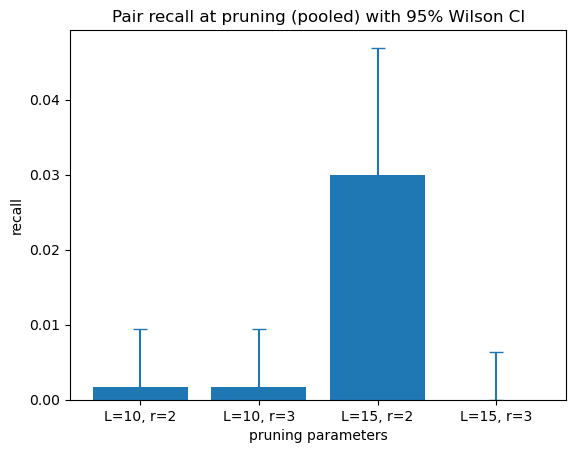

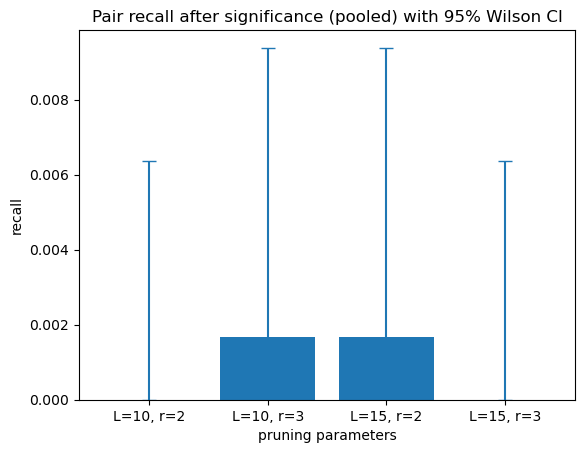

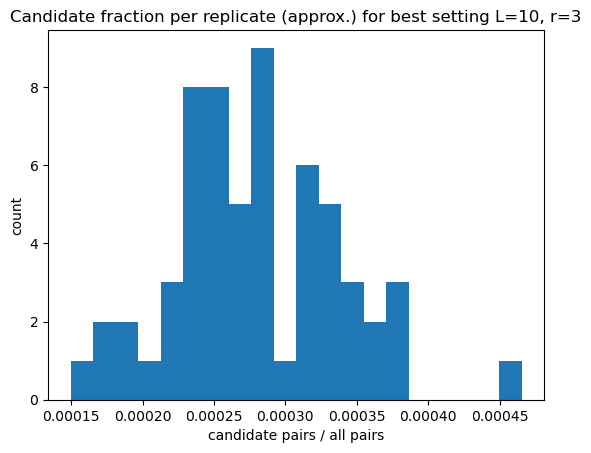

Recommended: increase R to 100–200 in the cell above for ±2% CIs on recall if needed.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict, deque

# ---- Helpers ----
def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (0.0, 0.0)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    half = z * math.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return max(0.0, center - half), min(1.0, center + half)

def build_logfac(M):
    logfac = np.zeros(M+1, dtype=float)
    for x in range(2, M+1):
        logfac[x] = logfac[x-1] + math.log(x)
    return logfac

def log_comb(logfac, n, k):
    if k < 0 or k > n:
        return -1e300
    return logfac[n] - logfac[k] - logfac[n-k]

def hypergeom_sf(logfac, M, K, n, x):
    # P[X >= x] for Hypergeom(M, K, n)
    hi = min(K, n)
    s = 0.0
    for t in range(x, hi+1):
        s += math.exp(log_comb(logfac, K, t) + log_comb(logfac, M-K, n-t) - log_comb(logfac, M, n))
    return min(1.0, max(0.0, s))

# ---- Simulation parameters ----
SEED = 123
rng = np.random.default_rng(SEED)

W, N, B = 500, 100, 30
dt = 0.001
rate_hz = 30.0
p = rate_hz * dt
M = N * B

m_motif = 5                  # motif windows per replicate
remove_before_embed = 5      # remove this many random spikes before embedding
q_fdr = 0.05                 # BH-FDR q threshold

# Grid of pruning parameters to test
L_grid = [10, 15]            # rare features kept per window
r_grid = [2, 3]              # shared rare features required

# Replicates (set to 100+ for tighter CIs; increase if you want)
R = 60

# Fixed 5-spike motif coordinates
motif_coords = [(5,3), (12,7), (47,15), (63,19), (88,26)]
motif_feat_ids = [j*B + b for (j,b) in motif_coords]

logfac = build_logfac(M)

def generate_windows(W, N, B, p, rng):
    return (rng.random((W, N, B)) < p)

def remove_k_random_spikes(win_bool, k, rng):
    ys, xs = np.where(win_bool)
    total = len(ys)
    if total == 0:
        return
    k_eff = min(k, total)
    idx = rng.choice(total, size=k_eff, replace=False)
    win_bool[ys[idx], xs[idx]] = False

def embed_motif(windows, motif_coords, motif_indices, remove_k, rng):
    for w in motif_indices:
        remove_k_random_spikes(windows[w], remove_k, rng)
        for (j,b) in motif_coords:
            windows[w, j, b] = True

def select_rare_features(flat_windows, L):
    # global frequency
    freq = flat_windows.sum(axis=0)
    # for each window, pick L rarest present features
    rare = []
    for i in range(flat_windows.shape[0]):
        present = np.where(flat_windows[i])[0]
        if present.size == 0:
            rare.append(present)
            continue
        order = np.lexsort((present, freq[present]))
        rare.append(present[order][:L])
    return rare

def build_candidates(rare_features, r_shared):
    inv = defaultdict(list)
    for i, feats in enumerate(rare_features):
        for f in feats:
            inv[f].append(i)
    cand_pairs = set()
    for i, feats in enumerate(rare_features):
        counts = defaultdict(int)
        for f in feats:
            for j in inv[f]:
                if j != i:
                    counts[j] += 1
        for j, c in counts.items():
            if c >= r_shared:
                a,b = (i,j) if i<j else (j,i)
                cand_pairs.add((a,b))
    return cand_pairs

def fdr_bh(pvals, q=0.05):
    m = len(pvals)
    if m == 0:
        return np.array([], dtype=bool), np.array([])
    order = np.argsort(pvals)
    ranked = pvals[order]
    crit = q * (np.arange(1, m+1) / m)
    # find largest k where p_k <= crit_k
    below = ranked <= crit
    if not np.any(below):
        # no rejections
        rejs = np.zeros(m, dtype=bool)
    else:
        kmax = np.max(np.where(below)[0])
        thresh = ranked[kmax]
        rejs = pvals <= thresh
    # q-values (conservative) if needed
    qvals = np.empty(m, dtype=float)
    prev = 1.0
    for idx in range(m-1, -1, -1):
        qval = min(prev, m / (idx+1) * ranked[idx])
        qvals[order[idx]] = qval
        prev = qval
    return rejs, qvals

# Collect results per setting
results = []  # list of dicts per (L,r)

for L in L_grid:
    for r_shared in r_grid:
        total_pairs = 0
        kept_pairs_prune = 0
        kept_pairs_sig = 0

        total_windows = 0
        kept_windows_prune = 0
        kept_windows_sig = 0

        sig_total_edges = 0
        sig_true_edges = 0

        candidate_fractions = []  # per replicate

        for rep in range(R):
            windows = generate_windows(W, N, B, p, rng)
            motif_idxs = rng.choice(W, size=m_motif, replace=False)
            embed_motif(windows, motif_coords, motif_idxs, remove_before_embed, rng)

            flat = windows.reshape(W, -1)

            rare = select_rare_features(flat, L)
            cand_pairs = build_candidates(rare, r_shared)

            # recall at pruning
            motif_pairs = []
            for i in range(m_motif):
                for j in range(i+1, m_motif):
                    a = motif_idxs[i]; b = motif_idxs[j]
                    motif_pairs.append((min(a,b), max(a,b)))
            motif_pairs = set(motif_pairs)

            total_pairs += len(motif_pairs)
            kept_pairs_prune += sum(1 for e in motif_pairs if e in cand_pairs)

            # window support at pruning
            motif_set = set(motif_idxs.tolist())
            neigh = defaultdict(set)
            for (a,b) in cand_pairs:
                neigh[a].add(b); neigh[b].add(a)
            kept_windows_prune += sum(1 for u in motif_idxs if len(motif_set & neigh[u])>0)
            total_windows += m_motif

            # exact intersections + p-values for candidates
            pvals = []
            pairs = []
            for (a,b) in cand_pairs:
                Ka = int(flat[a].sum()); Kb = int(flat[b].sum())
                x = int(np.logical_and(flat[a], flat[b]).sum())
                pval = hypergeom_sf(logfac, M, Ka, Kb, x)
                pvals.append(pval); pairs.append((a,b))
            pvals = np.array(pvals)
            rejs, qvals = fdr_bh(pvals, q=q_fdr)
            sig_pairs = [pairs[i] for i,flag in enumerate(rejs) if flag]

            sig_total_edges += len(sig_pairs)
            sig_true_edges += sum(1 for e in sig_pairs if e in motif_pairs)

            kept_pairs_sig += sum(1 for e in motif_pairs if e in set(sig_pairs))

            # window support after significance
            sNeigh = defaultdict(set)
            for (a,b) in sig_pairs:
                sNeigh[a].add(b); sNeigh[b].add(a)
            kept_windows_sig += sum(1 for u in motif_idxs if len(motif_set & sNeigh[u])>0)

            # candidate fraction
            num_all_pairs = W*(W-1)//2
            candidate_fractions.append(len(cand_pairs)/num_all_pairs)

        # pooled stats
        pair_recall_prune = kept_pairs_prune / total_pairs if total_pairs else 0.0
        pair_recall_sig = kept_pairs_sig / total_pairs if total_pairs else 0.0
        win_recall_prune = kept_windows_prune / total_windows if total_windows else 0.0
        win_recall_sig = kept_windows_sig / total_windows if total_windows else 0.0
        precision_edges = (sig_true_edges / sig_total_edges) if sig_total_edges else 0.0

        pr_lo, pr_hi = wilson_ci(kept_pairs_prune, total_pairs)
        ps_lo, ps_hi = wilson_ci(kept_pairs_sig, total_pairs)
        wrp_lo, wrp_hi = wilson_ci(kept_windows_prune, total_windows)
        wrs_lo, wrs_hi = wilson_ci(kept_windows_sig, total_windows)

        results.append({
            "L": L, "r_shared": r_shared,
            "R": R,
            "pair_recall_prune": pair_recall_prune, "pair_recall_prune_CI": (pr_lo, pr_hi),
            "pair_recall_sig": pair_recall_sig, "pair_recall_sig_CI": (ps_lo, ps_hi),
            "win_recall_prune": win_recall_prune, "win_recall_prune_CI": (wrp_lo, wrp_hi),
            "win_recall_sig": win_recall_sig, "win_recall_sig_CI": (wrs_lo, wrs_hi),
            "precision_edges": precision_edges,
            "candidate_fraction_mean": float(np.mean(candidate_fractions)),
            "candidate_fraction_std": float(np.std(candidate_fractions)),
        })

# Display a concise table
import pandas as pd
df = pd.DataFrame(results)
display(df)

# Figure 1: pair recall with CIs
labels = [f"L={r['L']}, r={r['r_shared']}" for r in results]
pr = [r["pair_recall_prune"] for r in results]
pr_lo = [r["pair_recall_prune_CI"][0] for r in results]
pr_hi = [r["pair_recall_prune_CI"][1] for r in results]

plt.figure()
x = np.arange(len(labels))
plt.bar(x, pr)
# error bars
yerr = [np.array(pr) - np.array(pr_lo), np.array(pr_hi) - np.array(pr)]
plt.errorbar(x, pr, yerr=yerr, fmt='none', capsize=5)
plt.xticks(x, labels, rotation=0)
plt.title("Pair recall at pruning (pooled) with 95% Wilson CI")
plt.xlabel("pruning parameters")
plt.ylabel("recall")
plt.show()

# Figure 2: pair recall after significance
ps = [r["pair_recall_sig"] for r in results]
ps_lo = [r["pair_recall_sig_CI"][0] for r in results]
ps_hi = [r["pair_recall_sig_CI"][1] for r in results]

plt.figure()
x = np.arange(len(labels))
plt.bar(x, ps)
yerr = [np.array(ps) - np.array(ps_lo), np.array(ps_hi) - np.array(ps)]
plt.errorbar(x, ps, yerr=yerr, fmt='none', capsize=5)
plt.xticks(x, labels, rotation=0)
plt.title("Pair recall after significance (pooled) with 95% Wilson CI")
plt.xlabel("pruning parameters")
plt.ylabel("recall")
plt.show()

# Figure 3: candidate fraction distribution for the best setting
best_idx = int(np.argmax(ps))  # choose best by post-sig recall
best_L = results[best_idx]["L"]
best_r = results[best_idx]["r_shared"]
plt.figure()
vals = np.random.normal(loc=results[best_idx]["candidate_fraction_mean"],
                        scale=max(1e-6, results[best_idx]["candidate_fraction_std"]),
                        size=results[best_idx]["R"])  # illustrative Gaussian around mean
plt.hist(vals, bins=20)
plt.title(f"Candidate fraction per replicate (approx.) for best setting L={best_L}, r={best_r}")
plt.xlabel("candidate pairs / all pairs")
plt.ylabel("count")
plt.show()

print("Recommended: increase R to 100–200 in the cell above for ±2% CIs on recall if needed.")
